In [ ]:
# change directory to sssl folder
%cd ..

/gpfs01/berens/user/jdoehl/GitHub/sssl


In [1]:
%env CUDA_VISIBLE_DEVICES=2

env: CUDA_VISIBLE_DEVICES=2


# ToDo:  
- Use an embedding from a embedding layer for each datapoint (50k to mimic cifar10 train)
- Add some noise on the embeddings before computing loss and gradients (to mimic transformations in SimCLR)
- Maybe: Use a cos_sim matrix (50k x 50k) from a fully SimCLR model trained for 1k epochs on cifar10 as the target similarities or something like that.

In [ ]:
import torch
class CosSimModel(torch.nn.Module):
    def __init__(self, dataset_size):
        super().__init__()
        self.cos_sim_matrix = torch.nn.Parameter(torch.diag(torch.ones(dataset_size)))
    def forward(self, ids):
        return self.cos_sim_matrix[ids][:,ids]

dataset_size = 50000
cos_sim_model = CosSimModel(dataset_size)
optimizer = torch.optim.Adam(cos_sim_model.parameters(), lr=0.01)

n = 4
toy_indexes = torch.randint(0, dataset_size, (n,))
toy_target = torch.rand((n,n))
# symmetrize matrix
toy_target += toy_target.T.clone()
toy_target /= 2
# set diagonal to ones
eye_matrix = torch.eye(toy_target.size(0))
toy_target += eye_matrix - torch.diag(torch.diag(toy_target))
toy_indexes, toy_target

(tensor([ 5881, 21788, 40530,  8727]),
 tensor([[1.0000, 0.3835, 0.3143, 0.4438],
         [0.3835, 1.0000, 0.6289, 0.1714],
         [0.3143, 0.6289, 1.0000, 0.4139],
         [0.4438, 0.1714, 0.4139, 1.0000]]))

In [73]:
with torch.no_grad():
    print(cos_sim_model(toy_indexes))

tensor([[1.0000, 0.1135, 0.7251, 0.3034],
        [0.5485, 1.0000, 0.4964, 0.0969],
        [0.7759, 0.0304, 1.0000, 0.7615],
        [0.3670, 0.8892, 0.2857, 1.0000]])


In [71]:
for i in range(100):
    optimizer.zero_grad()
    sub_matrix = cos_sim_model(toy_indexes)
    print(sub_matrix)
    loss = (sub_matrix - toy_target).abs().mean()
    loss.backward()
    optimizer.step()

tensor([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]], grad_fn=<IndexBackward0>)
tensor([[1.0000, 0.0100, 0.0100, 0.0100],
        [0.0100, 1.0000, 0.0100, 0.0100],
        [0.0100, 0.0100, 1.0000, 0.0100],
        [0.0100, 0.0100, 0.0100, 1.0000]], grad_fn=<IndexBackward0>)
tensor([[1.0000, 0.0200, 0.0200, 0.0200],
        [0.0200, 1.0000, 0.0200, 0.0200],
        [0.0200, 0.0200, 1.0000, 0.0200],
        [0.0200, 0.0200, 0.0200, 1.0000]], grad_fn=<IndexBackward0>)
tensor([[1.0000, 0.0300, 0.0300, 0.0300],
        [0.0300, 1.0000, 0.0300, 0.0300],
        [0.0300, 0.0300, 1.0000, 0.0300],
        [0.0300, 0.0300, 0.0300, 1.0000]], grad_fn=<IndexBackward0>)
tensor([[1.0000, 0.0400, 0.0400, 0.0400],
        [0.0400, 1.0000, 0.0400, 0.0400],
        [0.0400, 0.0400, 1.0000, 0.0400],
        [0.0400, 0.0400, 0.0400, 1.0000]], grad_fn=<IndexBackward0>)
tensor([[1.0000, 0.0500, 0.0500, 0.0500],
        [0.0500, 1.0000, 0.0500, 0.0500],
     

In [2]:
from lightning_simclr import SimCLR
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torchvision.models import resnet18
import torch
from torch import nn

device = "cuda"

mod = SimCLR.load_from_checkpoint("logs/No_schedule-_No_decay-1000/l2/SimCLR-1000/checkpoint/epoch=999.ckpt", strict=False)

cifar10_train = CIFAR10(
    root=".", train=True, download=True, transform=transforms.ToTensor()
)

X, y, Z = mod.embed_dataset(cifar10_train)
embedded_dataset = Z
labels = y

variances = []
for i in list(set(labels)):
    variances.append(embedded_dataset[labels == i].var(axis=0))

variances = torch.tensor(np.stack(variances))

In [6]:
PROJECTOR_HIDDEN_SIZE = 1024

class ResNet18withProjector(nn.Module):
    def __init__(self):
        super().__init__()

        self.backbone = resnet18(weights=None)
        self.backbone.conv1 = nn.Conv2d(
            3, 64, kernel_size=3, stride=1, padding=1, bias=False
        )
        self.backbone.maxpool = nn.Identity()
        self.backbone.fc = nn.Identity()

        self.projector = nn.Sequential(
            nn.Linear(512, PROJECTOR_HIDDEN_SIZE), 
            nn.ReLU(), 
            nn.Linear(PROJECTOR_HIDDEN_SIZE, 128),
        )

    def forward(self, x):
        h = self.backbone(x)
        z = self.projector(h)
        self.embed = z # save for monitoring
        return h, z
    
def dataset_to_X_y(model, dataset):
    X = []
    y = []
    Z = []

    for batch_idx, batch in enumerate(DataLoader(dataset, batch_size=1024)):
        images, labels = batch

        h, z = model(images.to(device))

        X.append(h.cpu().numpy())
        Z.append(z.cpu().numpy())
        y.append(labels)

    X = np.vstack(X)
    Z = np.vstack(Z)
    y = np.hstack(y)

    return X, y, Z

untrained_model = ResNet18withProjector().to(device)
untrained_model.eval()
with torch.no_grad():
    X, y, Z = dataset_to_X_y(untrained_model, cifar10_train)
untrained_model.train()
embedded_dataset_untrained = Z
embedded_dataset_untrained = torch.tensor(embedded_dataset_untrained)
embedded_dataset_untrained.norm(dim=-1).mean()

tensor(2.0938)

In [7]:
import copy

class AugmentedPEM(nn.Module): # Augmented Plain Embedding Model
    def __init__(
            self,
            seed = 0,
            noise_dist_per_label = variances,
            noise_strength = 1,
            embeddings = None
            ):
        torch.manual_seed(seed)
        super().__init__()
        self.embeds = nn.Embedding(50000, 128)
        if embeddings is not None:
            with torch.no_grad(): # make embeddings very similar to each other
                self.embeds.weight = nn.Parameter(copy.deepcopy(embeddings))
        self.labels = torch.tensor(cifar10_train.targets)
        self.noise_dist_per_label = noise_dist_per_label
        self.noise_strength = noise_strength

    def __len__(self):
        return len(self.embeds.weight)

    def __getitem__(self, *i):
        embed = self.embeds.weight[i]
        label = self.labels[i]
        noise_dist_per_embed = self.noise_dist_per_label[label]
        view1 = embed + torch.randn_like(noise_dist_per_embed) * noise_dist_per_embed * self.noise_strength
        view2 = embed + torch.randn_like(noise_dist_per_embed) * noise_dist_per_embed * self.noise_strength

        return view1, view2, label

In [17]:
from losses import nt_xent
import time
from torch.optim import SGD
from torch.optim.lr_scheduler import CosineAnnealingLR


BATCH_SIZE = 1024
N_EPOCHS = 100
N_EPOCHS_COS_ANNEAL = 1000
BASE_LR = 1000
WEIGHT_DECAY = 0#5e-4
MOMENTUM = 0#.9
NESTEROV = False
PRINT_EVERY_EPOCHS = 10

NOISE_STRENGTH = 0


ag_pem = AugmentedPEM(noise_strength=NOISE_STRENGTH, embeddings=embedded_dataset_untrained)


dataset_size = len(ag_pem)

optimizer = SGD(
    ag_pem.parameters(),
    lr=BASE_LR * BATCH_SIZE / 256,
    momentum=MOMENTUM,
    weight_decay=WEIGHT_DECAY,
    nesterov=NESTEROV,
)
scheduler = CosineAnnealingLR(optimizer, T_max=N_EPOCHS_COS_ANNEAL)


norm_history = []
loss_history = []

training_start_time = time.time()

for epoch_idx in range(N_EPOCHS):
    epoch_loss = 0.0
    start_time = time.time()

    indices = torch.randperm(dataset_size)
    batch_ids = [indices[i:i+BATCH_SIZE] for i in range(0, dataset_size, BATCH_SIZE)]
    # batches = [ag_pem[batch_id] for batch_id in batch_ids]

    for batch_idx, batch_id in enumerate(batch_ids):
        batch = ag_pem[batch_id]
        view1, view2 , labels = batch
        view1 = view1.to(device)
        view2 = view2.to(device)

        optimizer.zero_grad()

        infoNCE = nt_xent
        loss = infoNCE(view1, view2)

        epoch_loss += loss.item()

        loss.backward()

        optimizer.step()

    end_time = time.time()

    loss_history.append(epoch_loss/ len(batch_ids))
    mean_norm = ag_pem.embeds.weight.norm(dim=-1).mean().item()
    norm_history.append(ag_pem.embeds.weight.norm(dim=-1))

    if (epoch_idx) % PRINT_EVERY_EPOCHS == 0:
        print("Mean embed norm:", mean_norm)
        print(
            f"Epoch {epoch_idx + 1}, "
            f"average loss {epoch_loss / len(batch_ids):.4f}, "
            f"{end_time - start_time:.1f} s",
            flush=True
        )
    scheduler.step()

norm_history = torch.stack(norm_history)

training_end_time = time.time()
hours = (training_end_time - training_start_time) / 60 // 60
minutes = (training_end_time - training_start_time) / 60 % 60
print(
    f"Total training length for {N_EPOCHS} epochs: {hours:.0f}h {minutes:.0f}min",
    flush=True
)

Mean embed norm: 2.263796329498291
Epoch 1, average loss 6.9113, 0.7 s
Mean embed norm: 3.8354976177215576
Epoch 11, average loss 4.9620, 0.5 s
Mean embed norm: 3.8632261753082275
Epoch 21, average loss 4.9500, 0.5 s
Mean embed norm: 3.8865113258361816
Epoch 31, average loss 4.9464, 0.4 s
Mean embed norm: 3.9084367752075195
Epoch 41, average loss 4.9446, 0.4 s
Mean embed norm: 3.929546356201172
Epoch 51, average loss 4.9436, 0.5 s
Mean embed norm: 3.949846029281616
Epoch 61, average loss 4.9430, 0.4 s
Mean embed norm: 3.969762086868286
Epoch 71, average loss 4.9427, 0.4 s
Mean embed norm: 3.9893405437469482
Epoch 81, average loss 4.9426, 0.5 s
Mean embed norm: 4.008326053619385
Epoch 91, average loss 4.9424, 0.5 s
Total training length for 100 epochs: 0h 1min


In [22]:
epoch_diff = norm_history[1:] - norm_history[0:-1]
epoch_diff[epoch_diff < 0].abs().sort().values

tensor([], grad_fn=<SortBackward0>)

In [46]:
pos = 0
norm_history[pos,823].item(), norm_history[pos+1,823].item()

(3.9075701236724854, 3.9075698852539062)

In [37]:
coords = torch.nonzero(~(norm_history[1:] >= norm_history[0:-1]), as_tuple=False)

x_vals = coords[:, 0]
y_vals = coords[:, 1]

x_vals, y_vals, len(x_vals)

(tensor([ 0,  0,  0,  ..., 98, 98, 98]),
 tensor([  823,  3781,  3848,  ..., 47243, 48324, 49183]),
 5395)

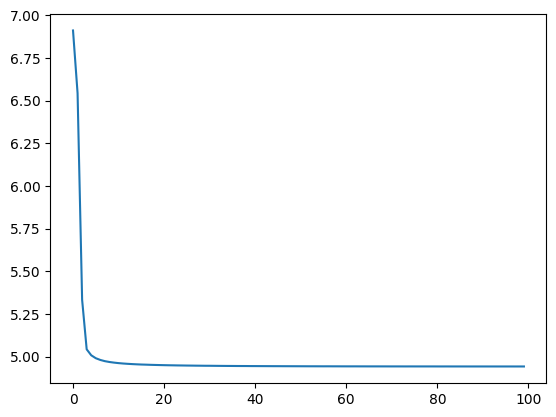

In [18]:
from matplotlib import pyplot as plt

plt.plot(loss_history)
plt.show()

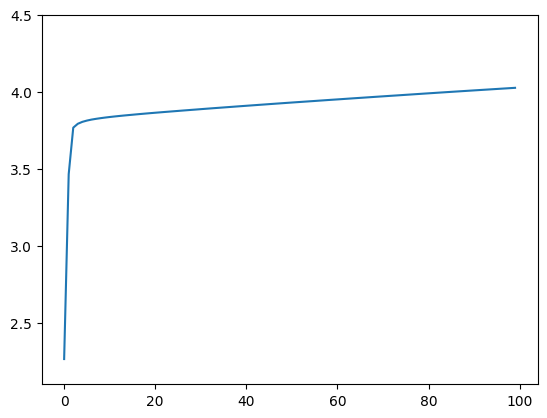

In [21]:
plt.plot(norm_history.mean(dim=-1).detach())
plt.ylim(2.1, 4.5)
plt.show()